In [3]:
%set_env OMP_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

env: OMP_NUM_THREADS=1


In [127]:
def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def simu(params, set_initial_conditions, logger):
    # params: dict containing all parameters
    # initial_conditions: function (dist, (xbasis, ybasis), c, v, m) -> None that should modify the [d3.Field]s c,v,m
    # logger: logging.Logger
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    mu = params["mu"]
    α  = params["α"]
    B = params.get('B', 1.)
    
    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.ChebyshevT( coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    tau_vy = dist.Field(name='tau_vy') #Residual for y-component of velocity
    tau_v1 = dist.VectorField(coords, name='tau_v1', bases=ybasis)
    tau_v2 = dist.VectorField(coords, name='tau_v2', bases=ybasis)

    #Substitutions
    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2

    ex, ey = coords.unit_vector_fields(dist)
    lift_basis = xbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_v = d3.grad(v) - ex*lift(tau_v1)

    # Time-dependent compressibility
    t = dist.Field()
    B = dist.ScalarField(name='B', bases=(xbasis, ybasis))
    B = 50 * np.tanh((t - 15) / 2) + 50

    # Static DV-aligned source
    DV = dist.TensorField(coords, name='DV', bases=(xbasis, ybasis))
    DV['g'][0,0,:,:] = 0
    DV['g'][0,1,:,:] = 0
    DV['g'][1,0,:,:] = 0
    DV['g'][1,1,:,:] = 1.

    #Static velocity Problem
    v_problem = d3.LBVP([v, tau_vy, tau_v1, tau_v2], namespace=locals())
    v_problem.add_equation("mu*div(grad_v) + B*grad(div(v)) + lift(tau_v2) + tau_vy*ey = -α * div(m) ") # Stokes equation (with tau residual)

    #Boundary conditions
    v_problem.add_equation("v(x=-Lx/2) = 0") #Dirichlet BCs 
    v_problem.add_equation("v(x=+Lx/2) = 0") #DIrichlet BC
    v_problem.add_equation("integ(v @ ey) = 0")   #No net y-flow gauge
    
    #Protein fields
    p_problem = d3.IVP([c, m], time=t, namespace=locals())
    p_problem.add_equation("dt(c) = - v@grad(c)") #Cadherin advection
    p_problem.add_equation(params['m_eq'])
    
    # Solvers
    p_solver = p_problem.build_solver(d3.SBDF2)
    p_solver.stop_sim_time = params['max_time']
    v_solver = v_problem.build_solver()

    # Initial conditions
    set_initial_conditions(dist=dist, bases=(xbasis, ybasis), params=params, c=c, v=v, m=m)
    
    # Main loop
    save_every = params["save_every"]
    t_list, c_list, m_list, v_list = [], [], [], []
    try:
        logger.info("Starting main loop")
        while p_solver.proceed:            
            v_solver.solve()
            if p_solver.iteration % save_every == 0:
                t_list.append(p_solver.sim_time)
                c_list.append(get_g_with_scales(c, (1,1)))
                m_list.append(get_g_with_scales(m, (1,1)))
                v_list.append(get_g_with_scales(v, (1,1)))
            p_solver.step(params['timestep'])

            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                raise Exception("computation diverges: adjust dt and/or dx")
            if (p_solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={p_solver.iteration}, Time={p_solver.sim_time}, dt={params['timestep']}")
    except:
        logger.error("Exception raised, triggering end of main loop.")
        raise
        
    return {"params": params, 
            "fields": {"c":c, "v": v, "m": m}, 
            "bases": (xbasis, ybasis),
            "trajectory": {"c": c_list, "v": v_list, "m": m_list, "t": t_list}}

def ics(dist, bases, params, c, v, m):
    xbasis, ybasis = bases
    x, y = dist.local_grids(xbasis, ybasis)
    Lx, Ly = params['Lx'], params['Ly']

    x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
    y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[1,1].T)(x, y)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[1,0].T)(x, y)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[0,0].T)(x, y)
        
    c['g'][:] = RectBivariateSpline(x0, y0, c0.T)(x, y)
    
    v["g"][:] = 0

In [138]:
def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]


def ics(dist, bases, params, c, v, m):
    xbasis, ybasis = bases
    x, y = dist.local_grids(xbasis, ybasis)
    Lx, Ly = params['Lx'], params['Ly']

    x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
    y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[1,1].T)(x, y)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[1,0].T)(x, y)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[0,0].T)(x, y)
        
    c['g'][:] = RectBivariateSpline(x0, y0, c0.T)(x, y)
    
    v["g"][:] = 0

def simu(params, set_initial_conditions, logger):
    # params: dict containing all parameters
    # initial_conditions: function (dist, (xbasis, ybasis), c, v, m) -> None that should modify the [d3.Field]s c,v,m
    # logger: logging.Logger
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    mu = params["mu"]
    α  = params["α"]
    B = params.get('B', 1.)
    
    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.ChebyshevT( coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    tau_vy = dist.Field(name='tau_vy') #Residual for y-component of velocity
    tau_v1 = dist.VectorField(coords, name='tau_v1', bases=ybasis)
    tau_v2 = dist.VectorField(coords, name='tau_v2', bases=ybasis)

    #Substitutions
    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2

    ex, ey = coords.unit_vector_fields(dist)
    lift_basis = xbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_v = d3.grad(v) - ex*lift(tau_v1)

    # Time-dependent compressibility
    t = dist.Field()
    B = dist.ScalarField(name='B', bases=(xbasis, ybasis))
    B = 50 * np.tanh((t - 15) / 2) + 50

    # Static DV-aligned source
    DV = dist.TensorField(coords, name='DV', bases=(xbasis, ybasis))
    DV['g'][0,0,:,:] = 0
    DV['g'][0,1,:,:] = 0
    DV['g'][1,0,:,:] = 0
    DV['g'][1,1,:,:] = 1.

    #Static velocity Problem
    v_problem = d3.LBVP([v, tau_vy, tau_v1, tau_v2], namespace=locals())
    v_problem.add_equation("mu*div(grad_v) + B*grad(div(v)) + lift(tau_v2) + tau_vy*ey = -α * div(m) ") # Stokes equation (with tau residual)

    #Boundary conditions
    v_problem.add_equation("v(x=-Lx/2) = 0") #Dirichlet BCs 
    v_problem.add_equation("v(x=+Lx/2) = 0") #DIrichlet BC
    v_problem.add_equation("integ(v @ ey) = 0")   #No net y-flow gauge
    
    #Protein fields
    p_problem = d3.IVP([c, m], time=t, namespace=locals())
    p_problem.add_equation("dt(c) = - v@grad(c)") #Cadherin advection
    p_problem.add_equation(params['m_eq'])
    
    # Initial conditions
    set_initial_conditions(dist=dist, bases=(xbasis, ybasis), params=params, c=c, v=v, m=m)

    # Solvers
    p_solver = p_problem.build_solver(d3.SBDF2)
    p_solver.stop_sim_time = params['max_time']
    v_solver = v_problem.build_solver()
    
    # Main loop
    save_every = params["save_every"]
    t_list, c_list, m_list, v_list = [], [], [], []
    try:
        logger.info("Starting main loop")
        while p_solver.proceed:
            v_problem.build_solver().solve()       
            if p_solver.iteration % save_every == 0:
                t_list.append(p_solver.sim_time)
                c_list.append(get_g_with_scales(c, (1,1)))
                m_list.append(get_g_with_scales(m, (1,1)))
                v_list.append(get_g_with_scales(v, (1,1)))
            p_solver.step(params['timestep'])

            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                raise Exception("computation diverges: adjust dt and/or dx")
            if (p_solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={p_solver.iteration}, Time={p_solver.sim_time}, dt={params['timestep']}")
    except:
        logger.error("Exception raised, triggering end of main loop.")
        raise
        
    return {"params": params, 
            "fields": {"c":c, "v": v, "m": m}, 
            "bases": (xbasis, ybasis),
            "trajectory": {"c": c_list, "v": v_list, "m": m_list, "t": t_list}}

Initial time = 0
2024-05-17 13:53:09,529 dedalus 0/1 INFO :: Starting main loop
2024-05-17 13:53:10,006 dedalus 0/1 INFO :: Iteration=1, Time=0.1, dt=0.1
2024-05-17 13:53:53,286 dedalus 0/1 INFO :: Iteration=101, Time=10.09999999999998, dt=0.1
2024-05-17 13:54:36,594 dedalus 0/1 INFO :: Iteration=201, Time=20.100000000000016, dt=0.1
2024-05-17 13:55:19,489 solvers 0/1 INFO :: Simulation stop time reached.


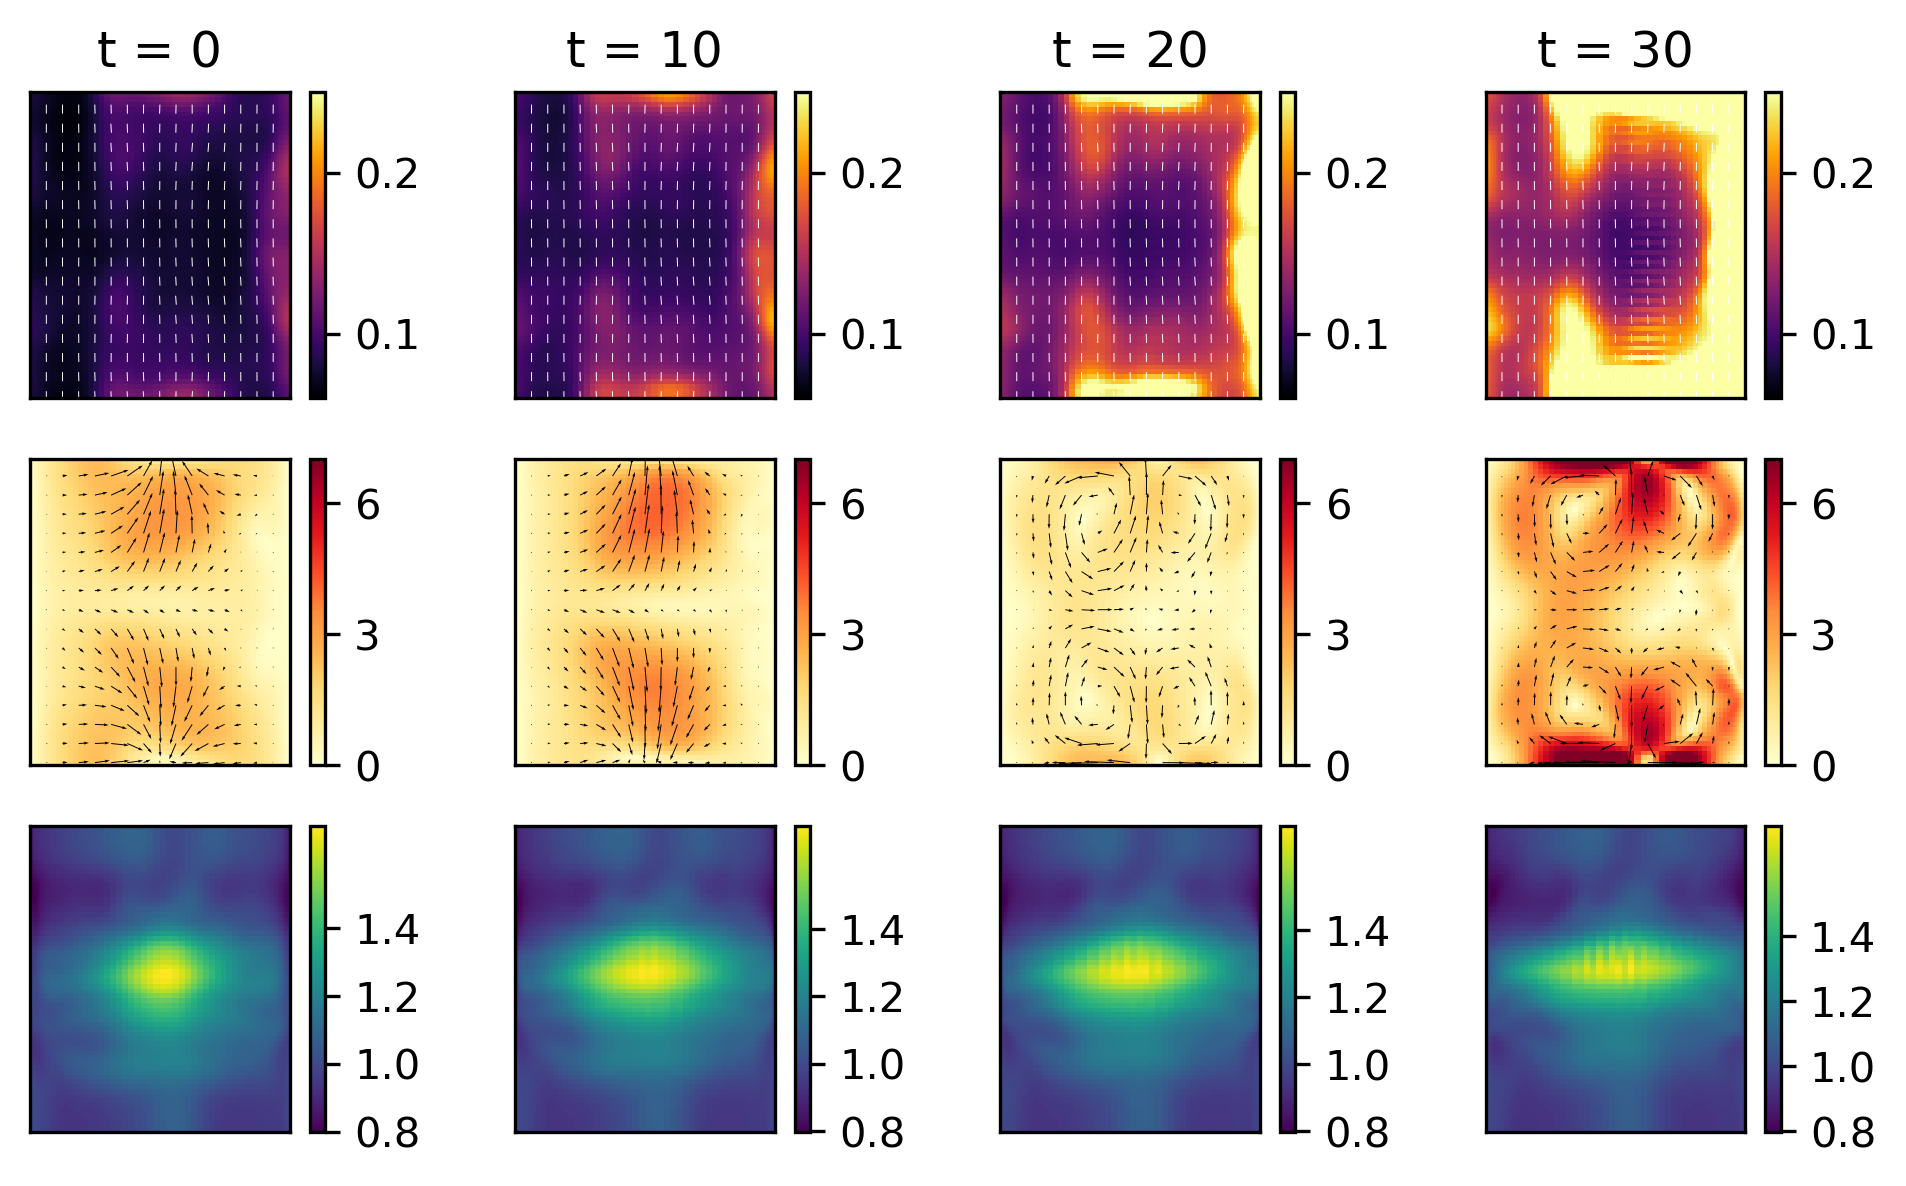

In [139]:
from scipy.interpolate import RectBivariateSpline


with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    tmin = 0
    
    t0 = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t0 >= tmin, t0 <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    c0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t0[t_mask, ...][()]

    c0 = 0.5 * (c0 + c0[::-1, :])

folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 0
print(f'Initial time = {t0[tt]}')
m0 = m0[tt]
v0 = v0[tt]
c0 = c0[tt]

m_eq = 'dt(m) = '
m_eq += ' - (Ω @ m - m @ Ω)  - v @ grad(m)'
m_eq += ' - (0.066 - 0.061 * c) * m' 
m_eq += ' + (0.564 - 0.393 * c) * m * trace(m)'
m_eq += ' + (0.489 + 0.318 * c) * m * trace(E)'
m_eq += ' + (0.047 - 0.037 * c) * DV * trace(m)'

params = dict(
    mu = 1., α = 5.,
    m_ic=None, c_ic=None,
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,
    max_time=30, timestep=0.1, save_every=5,
    m_eq=m_eq
)
logging.getLogger('subsystems').setLevel('ERROR')
logger = logging.getLogger('dedalus')
logger.setLevel(logging.INFO)
data = simu(params, ics, logger)
x = np.squeeze(data["bases"][0].local_grid(dist, 1))
y = np.squeeze(data["bases"][1].local_grid(dist, 1))

kwargs = dict(vmax=.5, mmin=0.06, mmax=0.2, skip=4)
c1, v1, m1, t1 = data["trajectory"]["c"], data["trajectory"]["v"], data["trajectory"]["m"], data['trajectory']['t']

times = [0, 10, 20, 30]
fig, ax = plt.subplots(3, len(times), dpi=300, figsize=(len(times)*2, 4.5))

for i, tt in enumerate(times):
    idx = np.argmin(np.abs(np.array(t1) - tt))

    # Plot fields
    mij = m1[idx].transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]

    pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.05, vmax=0.3)
    ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                pivot='middle', color='white',
                headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[0,i], ticks=[0.1, 0.2])
  
    pcV = ax[1,i].pcolormesh(x, y, np.linalg.norm(v1[idx], axis=0).T, vmin=0, vmax=7, cmap='YlOrRd')
    ax[1,i].quiver(X, Y, v1[idx][0, ::4, ::4].T, v1[idx][1, ::4, ::4].T, 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[1,i], ticks=[0, 3, 6])

    pcV = ax[2,i].pcolormesh(x, y, c1[idx],cmap='viridis')
    cb = plt.colorbar(pcV, ax=ax[2,i], ticks=[0.8, 1, 1.2, 1.4])

    ax[0, i].set_title(f't = {tt}')

for a in ax.flatten():
    a.set(aspect='equal', xticks=[], yticks=[])